Total sweeps processed: 92


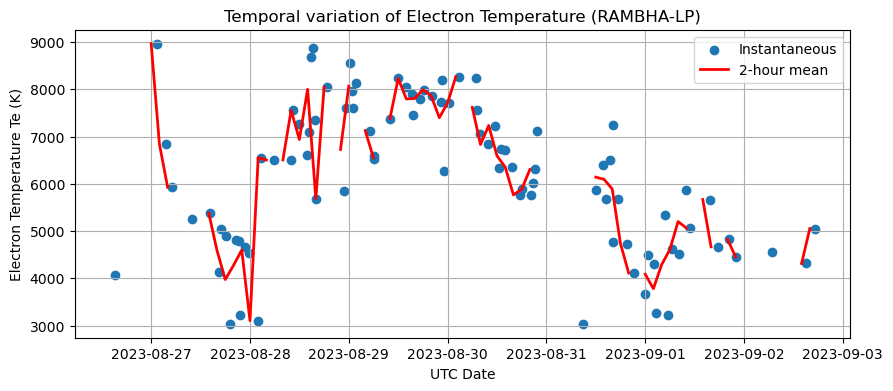

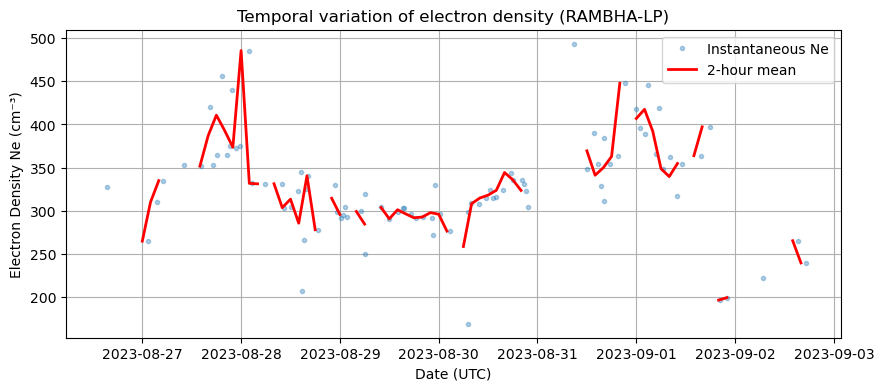

In [1]:
#Cell 1: Imports & constants

%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Physical constants
e  = 1.602176634e-19
kB = 1.380649e-23
m_e = 9.10938356e-31  # electron mass

# Probe geometry 
probe_radius = 0.025   # 2.5 cm radius
probe_area = 4 * np.pi * probe_radius**2



#Cell 2: Langmuir probe physics (OML method)

def electron_current(V, I):
    mask = V < (np.min(V) + 0.2 * (np.max(V) - np.min(V)))
    if mask.sum() < 5:
        I_isat = np.median(I[:5])
    else:
        I_isat = np.median(I[mask])

    Ie = I - I_isat
    return Ie, I_isat


def average_by_voltage(V, I):
    df = pd.DataFrame({"V": V, "I": I})
    df = df.groupby("V", as_index=False).mean()
    return df["V"].values, df["I"].values

def floating_potential(V, I):
    # Sort by current for interpolation
    idx = np.argsort(I)
    I_sorted = I[idx]
    V_sorted = V[idx]
    
    # Check zero crossing exists
    if np.min(I_sorted) > 0 or np.max(I_sorted) < 0:
        return np.nan
    
    return np.interp(0.0, I_sorted, V_sorted)


def plasma_potential(V, I):
    if len(V) < 10:
        return np.nan
    
    dIdV = np.gradient(I, V)
    
    # Remove NaNs/Infs caused by numerical issues
    dIdV = np.nan_to_num(dIdV, nan=0.0, posinf=0.0, neginf=0.0)
    
    return V[np.argmax(dIdV)]


def electron_temperature(V, I, Vp):
    Ie, _ = electron_current(V, I)

    # Electron retardation region (RAMBHA-LP style)
    region = (V > Vp - 8) & (V < Vp - 5) & (Ie > 0)

    Vc = V[region]
    Ie_c = Ie[region]

    if len(Vc) < 6:
        return np.nan, np.nan

    lnIe = np.log(Ie_c)

    # Linear fit
    slope, intercept, r, _, _ = linregress(Vc, lnIe)

    if slope <= 0:
        return np.nan, np.nan

    # Model prediction
    lnIe_fit = slope * Vc + intercept

    # --- NRMSE calculation ---
    rmse = np.sqrt(np.mean((lnIe - lnIe_fit)**2))
    nrmse = rmse / (np.max(lnIe) - np.min(lnIe))

    Te = e / (kB * slope)

    return Te, nrmse


def ion_saturation_current(I):
    n = max(5, int(0.1 * len(I)))
    return np.median(I[:n])


def electron_density(V, I, Te, Vp):
    """
    Use raw current (photoemission already removed),
    extrapolated electron branch to plasma potential
    """

    # Use only electron retardation region
    region = (V > Vp - 8) & (V < Vp - 3)

    if region.sum() < 5:
        return np.nan

    Vc = V[region]
    Ic = I[region]

    # Linear fit in ln(I)–V space
    slope, intercept, _, _, _ = linregress(Vc, np.log(Ic))

    # Extrapolate to plasma potential
    Ie_Vp = np.exp(slope * Vp + intercept)

    if Ie_Vp <= 0:
        return np.nan

    vt = np.sqrt(8 * kB * Te / (np.pi * m_e))

    Ne = Ie_Vp / (0.25 * e * probe_area * vt)

    return Ne


#Cell 3: Read ALL RAMBHA data correctly

base_path = r"D:\Jupyter\raw"
records = []

for folder in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    files = os.listdir(folder_path)

    ops_files = sorted([f for f in files if "_ops_" in f and f.endswith(".csv")])
    sci_files = sorted([f for f in files if "_sci_" in f and f.endswith(".csv")])

    if len(ops_files) == 0 or len(sci_files) == 0:
        print(f"Skipping {folder} (no ops or sci CSV files)")
        continue

    for ops_file, sci_file in zip(ops_files, sci_files):

        # ---- OPS: metadata ----
        ops_df = pd.read_csv(os.path.join(folder_path, ops_file))
        ops_df.columns = ops_df.columns.astype(str).str.strip()

        time_col = [c for c in ops_df.columns if "Start_time" in c][0]
        time_utc = pd.to_datetime(ops_df[time_col].iloc[0])

        # ---- SCI: V-I sweep ----

        sci_df = pd.read_csv(
            os.path.join(folder_path, sci_file),
            header=None,
            low_memory=False
        )

        # Force numeric conversion (strings → NaN)
        sci_df[0] = pd.to_numeric(sci_df[0], errors="coerce")
        sci_df[1] = pd.to_numeric(sci_df[1], errors="coerce")

        # Drop non-numeric rows
        sci_df.dropna(subset=[0, 1], inplace=True)

        # Convert to numpy float arrays
        V = sci_df.iloc[:, 0].astype(float).values
        I = sci_df.iloc[:, 1].astype(float).values
        V = sci_df.iloc[:, 0].astype(float).values
        I = sci_df.iloc[:, 1].astype(float).values

        # Sort by voltage
        idx = np.argsort(V)
        V = V[idx]
        I = I[idx]

        V, I = average_by_voltage(V, I)

        # Relaxed sanity check
        if len(V) < 20 or (np.nanmax(V) - np.nanmin(V)) < 3:
            continue


        # Sanity check: valid sweep
        if len(V) < 50 or np.nanmax(V) - np.nanmin(V) < 5:
            continue


        Vf = floating_potential(V, I)
        Vp = plasma_potential(V, I)
        Te, nrmse = electron_temperature(V, I, Vp)

        if np.isnan(Te):
            continue

        if nrmse > 0.2:
            continue

        if np.isnan(Te):
            continue

        Ne = electron_density(V, I, Te, Vp)  

        Te_err, Ne_err = np.nan, np.nan

        records.append([
            time_utc,
            Vf, Vp,
            Te, nrmse,
            Ne / 1e6, np.nan
        ])



#Cell 4: Create dataframe & 2-hour averages

print("Total sweeps processed:", len(records))

df = pd.DataFrame(records, columns=[
    "Time_UTC", "Vf", "Vp",
    "Te_K", "Te_err",
    "Ne_cm3", "Ne_err"
])

df["Time_UTC"] = pd.to_datetime(df["Time_UTC"])
df.set_index("Time_UTC", inplace=True)

df_2h = df.resample("2h").mean()

#Electron temperature (Te)

plt.figure(figsize=(10,4))
plt.scatter(df.index, df["Te_K"], label="Instantaneous")
plt.plot(df_2h.index, df_2h["Te_K"], '-r', lw=2, label="2-hour mean")
plt.ylabel("Electron Temperature Te (K)")
plt.xlabel("UTC Date")
plt.legend()
plt.grid(True)
plt.title("Temporal variation of Electron Temperature (RAMBHA-LP)")
plt.show()


#Electron density (Ne)

plt.figure(figsize=(10,4))
plt.plot(df.index, df["Ne_cm3"], '.', alpha=0.35, label="Instantaneous Ne")
plt.plot(df_2h.index, df_2h["Ne_cm3"], 'r', lw=2, label="2-hour mean")
plt.ylabel("Electron Density Ne (cm⁻³)")
plt.xlabel("Date (UTC)")
plt.legend()
plt.grid(True)
plt.title("Temporal variation of electron density (RAMBHA-LP)")
plt.show()

df.to_csv(r"D:\Jupyter\raw\rambha_lp_Te_Ne_extracted2.csv")
